# Dipy Simulations (with Rician noise at different SNRs)

First let's load relevant modules

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.sims.voxel import (multi_tensor_dki, single_tensor, multi_tensor, 
                             _check_directions, all_tensor_evecs)
from dipy.data import (get_fnames, get_sphere)
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import (decompose_tensor, from_lower_triangular)
from dipy.sims.voxel import add_noise
from dipy.data import get_sphere
from dipy.reconst.dti import fractional_anisotropy
from dipy.viz import window, actor
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
import dipy.reconst.msdki as msdki
sphere = get_sphere('repulsion724')

The synthetic signals for each set of ground truth parameters are generated according to the gradient directions and b-values of the CFIN dataset. So let's load a object containing the acquisition parameters of the CFIN dataset.

In [2]:
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

In [3]:
bval1000 = gtab.bvals == 1000
bval2000 = gtab.bvals == 2000
bval3000 = gtab.bvals == 3000
bval_sel = bval1000 | bval2000 | bval3000

In [4]:
bvals = gtab.bvals[bval_sel]
bvecs = gtab.bvecs[bval_sel, :]

# add 6 b-values
bvals = np.hstack((np.zeros(6), bvals))
bvecs = np.vstack((np.zeros((6, 3)), bvecs))
gtab = gradient_table(bvals, bvecs)

## Voxel case 2

In [5]:
eval1 = [1.4e-3, 0.1e-3, 0.1e-3]
eval2 = [2.0e-3, 0.5e-3, 0.5e-3]
angle1 = (130.0, 0.0)
angle2 = (130.0, 0.0)
stick1 = _check_directions([angle1])
stick2 = _check_directions([angle2])
evec1 = all_tensor_evecs(stick1[0])
evec2 = all_tensor_evecs(stick2[0])

In [6]:
# Ground truth parameters
mevals = [eval1, eval2]
S0 = 1
angles = [angle1, angle2]
fractions = [50, 50]

signal2_gt, st = multi_tensor(gtab, mevals, S0, angles, fractions, snr=None)

dki_model = dki.DiffusionKurtosisModel(gtab, fit_method='NLS')
dki_fit = dki_model.fit(signal2_gt)
md_gt = dki_fit.md
ad_gt = dki_fit.ad
rd_gt = dki_fit.rd
fa_gt = dki_fit.fa

mk_gt = dki_fit.mk()
ak_gt = dki_fit.ak()
rk_gt = dki_fit.rk()
kfa_gt = dki_fit.kfa
mkt_gt = dki_fit.mkt()

msdki_model = msdki.MeanDiffusionKurtosisModel(gtab)
msdki_fit = msdki_model.fit(signal2_gt)
msk_gt = msdki_fit.msk

In [7]:
# Produce simulated signals for different SNRs
SNRs = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
nrep = 1000
DWI_simulates = np.empty((SNRs.size, nrep, gtab.bvals.size))

for si in range(10):
    snri =  SNRs[si]
    for ri in range(nrep):
        signal2, st = multi_tensor(gtab, mevals, 1.0, angles, fractions, snr=snri)
        DWI_simulates[si, ri, :] = signal2
    print(snri)

10
20
30
40
50
60
70
80
90
100


Let's fit DKI using DIPY's implementations

In [8]:
dki_fit = dki_model.fit(DWI_simulates)
MD = dki_fit.md
AD = dki_fit.ad
RD = dki_fit.rd
FA = dki_fit.fa

MK = dki_fit.mk()
AK = dki_fit.ak()
RK = dki_fit.rk()
KFA = dki_fit.kfa
MKT = dki_fit.mkt()

msdki_fit = msdki_model.fit(DWI_simulates)
MSK = msdki_fit.msk

(0.7, 0.9)

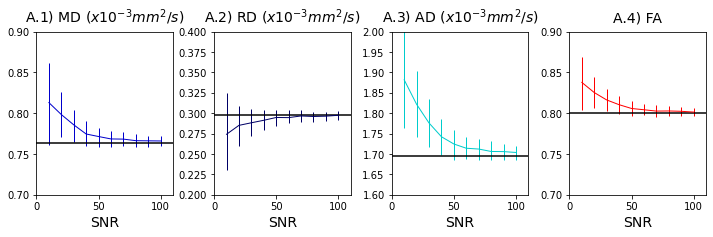

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.subplots_adjust(hspace=1, wspace=0.3)

# Initializing vectors for statistics
median_p = np.empty(SNRs.size)
lower_p = np.empty(SNRs.size)
upper_p = np.empty(SNRs.size)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MD[snri, :]*1000)
    p25, p75 = np.percentile(MD[snri, :]*1000, [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[0].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.0, 0.8], ecolor= [0.0, 0.0, 0.8],
                linewidth=1.0)
axs[0].hlines(md_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
# axs[0].set_ylim([md_gt*1000*0.9, md_gt*1000*1.1])
axs[0].set_xlim([0, 110])
axs[0].set_xlabel('SNR', fontsize=14)
axs[0].set_title('A.1) MD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)


for snri in range(SNRs.size):
    median_p[snri] = np.median(RD[snri, :]*1000)
    p25, p75 = np.percentile(RD[snri, :]*1000, [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[1].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.0, 0.4], ecolor= [0.0, 0.0, 0.4],
                linewidth=1.0)
axs[1].hlines(rd_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[1].set_xlim([0, 110])
axs[1].set_xlabel('SNR', fontsize=14)
axs[1].set_title('A.2) RD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)



for snri in range(SNRs.size):
    median_p[snri] = np.median(AD[snri, :]*1000)
    p25, p75 = np.percentile(AD[snri, :]*1000, [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[2].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.8, 0.8], ecolor= [0.0, 0.8, 0.8],
                linewidth=1.0)
axs[2].hlines(ad_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[2].set_xlim([0, 110])
axs[2].set_xlabel('SNR', fontsize=14)
axs[2].set_title('A.3) AD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)

for snri in range(SNRs.size):
    median_p[snri] = np.median(FA[snri, :])
    p25, p75 = np.percentile(FA[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[3].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[1.0, 0.0, 0.0], ecolor= [1.0, 0.0, 0.0],
                linewidth=1.0)
axs[3].hlines(fa_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
axs[3].set_xlim([0, 110])
axs[3].set_xlabel('SNR', fontsize=14)
axs[3].set_title('A.4) FA', fontsize=14, pad=10)


axs[0].set_ylim([0.7, 0.9])
axs[1].set_ylim([0.2, 0.4])
axs[2].set_ylim([1.6, 2.0])
axs[3].set_ylim([0.7, 0.9])

(0.3, 1.0)

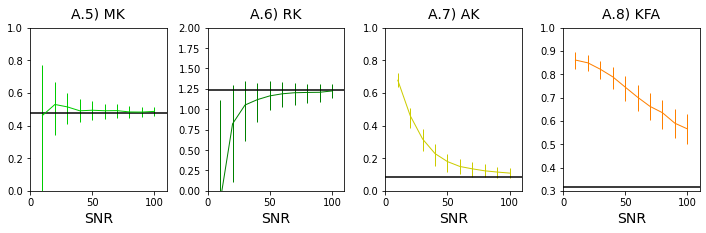

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Initializing vectors for statistics
median_p = np.empty(SNRs.size)
lower_p = np.empty(SNRs.size)
upper_p = np.empty(SNRs.size)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MK[snri, :])
    p25, p75 = np.percentile(MK[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[0].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.8, 0.0], ecolor= [0.0, 0.8, 0.0],
                linewidth=1.0)
axs[0].hlines(mk_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
# axs[0].set_ylim([md_gt*1000*0.9, md_gt*1000*1.1])
axs[0].set_xlim([0, 110])
axs[0].set_xlabel('SNR', fontsize=14)
axs[0].set_title('A.5) MK', fontsize=14, pad=10)


for snri in range(SNRs.size):
    median_p[snri] = np.median(RK[snri, :])
    p25, p75 = np.percentile(RK[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[1].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.5, 0.0], ecolor= [0.0, 0.5, 0.0],
                linewidth=1.0)
axs[1].hlines(rk_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[1].set_xlim([0, 110])
axs[1].set_xlabel('SNR', fontsize=14)
axs[1].set_title('A.6) RK', fontsize=14, pad=10)



for snri in range(SNRs.size):
    median_p[snri] = np.median(AK[snri, :])
    p25, p75 = np.percentile(AK[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[2].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.8, 0.8, 0.0], ecolor= [0.8, 0.8, 0.0],
                linewidth=1.0)
axs[2].hlines(ak_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[2].set_xlim([0, 110])
axs[2].set_xlabel('SNR', fontsize=14)
axs[2].set_title('A.7) AK', fontsize=14, pad=10)

for snri in range(SNRs.size):
    median_p[snri] = np.median(KFA[snri, :])
    p25, p75 = np.percentile(KFA[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[3].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[1, 0.5, 0.], ecolor=[1, 0.5, 0.],
                linewidth=1.0)
axs[3].hlines(kfa_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
axs[3].set_xlim([0, 110])
axs[3].set_xlabel('SNR', fontsize=14)
axs[3].set_title('A.8) KFA', fontsize=14, pad=10)

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 2])
axs[2].set_ylim([0, 1])
axs[3].set_ylim([0.3, 1])

For a reference let's plot here the same plots for MSK and MKT. Note that MSK cannot be computed from pyDesigner

(0.0, 1.0, 0.0, 1.0)

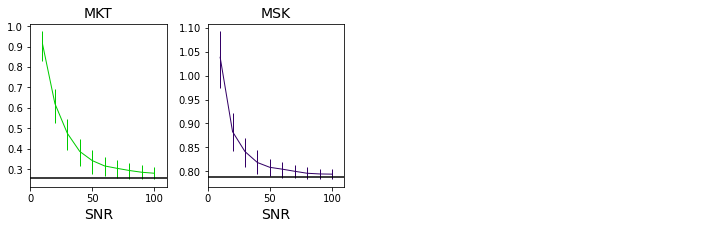

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Initializing vectors for statistics
median_p = np.empty(SNRs.size)
lower_p = np.empty(SNRs.size)
upper_p = np.empty(SNRs.size)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MKT[snri, :])
    p25, p75 = np.percentile(MKT[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[0].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.8, 0.0], ecolor= [0.0, 0.8, 0.0],
                linewidth=1.0)
axs[0].hlines(mkt_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
# axs[0].set_ylim([md_gt*1000*0.9, md_gt*1000*1.1])
axs[0].set_xlim([0, 110])
axs[0].set_xlabel('SNR', fontsize=14)
axs[0].set_title('MKT', fontsize=14)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MSK[snri, :])
    p25, p75 = np.percentile(MSK[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[1].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.2, 0.0, 0.4], ecolor= [0.2, 0.0, 0.4],
                linewidth=1.0)
axs[1].hlines(msk_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[1].set_xlim([0, 110])
axs[1].set_xlabel('SNR', fontsize=14)
axs[1].set_title('MSK', fontsize=14)

axs[2].axis('off')
axs[3].axis('off')

Let's now run pydesigner using its default fitting routine with no parameter constraints.

In [12]:
from designer.fitting.dwipy import DWI

# We have to save the data in nii, bvec and bvals files according to pydesigner requirements
np.savetxt('dwi.bvals', bvals)
np.savetxt('dwi.bvecs', bvecs.T)
nib.save(nib.Nifti1Image(DWI_simulates.reshape((10, 100, 10, gtab.bvals.shape[0])), np.eye(4)), "sim.nii.gz")

In [13]:
my_dwi = DWI("sim.nii.gz", bvecPath='dwi.bvecs', bvalPath='dwi.bvals')

No brain mask supplied
Image sim.nii.nii loaded successfully
Processing with 8 workers...


In [14]:
my_dwi.fit()

Unconstrained Tensor Fit: [100%]


In [15]:
md, rd, ad, fa, fe, trace  = my_dwi.extractDTI()

DTI Parameters: [100%]


In [16]:
mk, rk, ak, kfa, mkt, trace = my_dwi.extractDKI()

DKI Parameters: [100%]


In [17]:
#Reshape to previous data format (matrix with dimensions corresponding to SNRs testes and simulation repetitions)
MDpy = md.reshape((10, 1000))
ADpy = ad.reshape((10, 1000))
RDpy = rd.reshape((10, 1000))
FApy = fa.reshape((10, 1000))

MKpy = mk.reshape((10, 1000))
AKpy = ak.reshape((10, 1000))
RKpy = rk.reshape((10, 1000))
KFApy = kfa.reshape((10, 1000))

(0.7, 0.9)

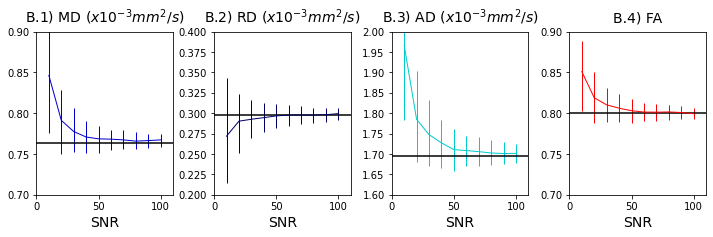

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.subplots_adjust(hspace=1, wspace=0.3)

# Initializing vectors for statistics
median_p = np.empty(SNRs.size)
lower_p = np.empty(SNRs.size)
upper_p = np.empty(SNRs.size)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MDpy[snri, :])
    p25, p75 = np.percentile(MDpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[0].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.0, 0.8], ecolor= [0.0, 0.0, 0.8],
                linewidth=1.0)
axs[0].hlines(md_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
# axs[0].set_ylim([md_gt*1000*0.9, md_gt*1000*1.1])
axs[0].set_xlim([0, 110])
axs[0].set_xlabel('SNR', fontsize=14)
axs[0].set_title('B.1) MD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)


for snri in range(SNRs.size):
    median_p[snri] = np.median(RDpy[snri, :])
    p25, p75 = np.percentile(RDpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[1].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.0, 0.4], ecolor= [0.0, 0.0, 0.4],
                linewidth=1.0)
axs[1].hlines(rd_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[1].set_xlim([0, 110])
axs[1].set_xlabel('SNR', fontsize=14)
axs[1].set_title('B.2) RD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)



for snri in range(SNRs.size):
    median_p[snri] = np.median(ADpy[snri, :])
    p25, p75 = np.percentile(ADpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[2].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.8, 0.8], ecolor= [0.0, 0.8, 0.8],
                linewidth=1.0)
axs[2].hlines(ad_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[2].set_xlim([0, 110])
axs[2].set_xlabel('SNR', fontsize=14)
axs[2].set_title('B.3) AD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)

for snri in range(SNRs.size):
    median_p[snri] = np.median(FApy[snri, :])
    p25, p75 = np.percentile(FApy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[3].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[1.0, 0.0, 0.0], ecolor= [1.0, 0.0, 0.0],
                linewidth=1.0)
axs[3].hlines(fa_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
axs[3].set_xlim([0, 110])
axs[3].set_xlabel('SNR', fontsize=14)
axs[3].set_title('B.4) FA', fontsize=14, pad=10)


axs[0].set_ylim([0.7, 0.9])
axs[1].set_ylim([0.2, 0.4])
axs[2].set_ylim([1.6, 2.0])
axs[3].set_ylim([0.7, 0.9])

(0.3, 1.0)

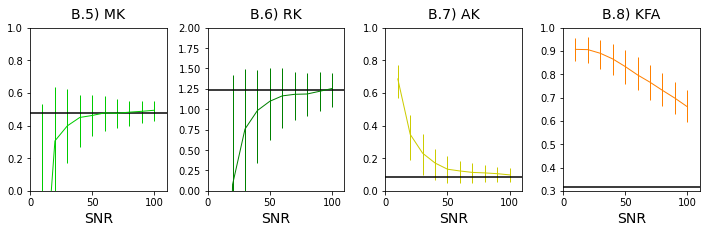

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Initializing vectors for statistics
median_p = np.empty(SNRs.size)
lower_p = np.empty(SNRs.size)
upper_p = np.empty(SNRs.size)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MKpy[snri, :])
    p25, p75 = np.percentile(MKpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[0].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.8, 0.0], ecolor= [0.0, 0.8, 0.0],
                linewidth=1.0)
axs[0].hlines(mk_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
# axs[0].set_ylim([md_gt*1000*0.9, md_gt*1000*1.1])
axs[0].set_xlim([0, 110])
axs[0].set_xlabel('SNR', fontsize=14)
axs[0].set_title('B.5) MK', fontsize=14, pad=10)


for snri in range(SNRs.size):
    median_p[snri] = np.median(RKpy[snri, :])
    p25, p75 = np.percentile(RKpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[1].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.5, 0.0], ecolor= [0.0, 0.5, 0.0],
                linewidth=1.0)
axs[1].hlines(rk_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[1].set_xlim([0, 110])
axs[1].set_xlabel('SNR', fontsize=14)
axs[1].set_title('B.6) RK', fontsize=14, pad=10)



for snri in range(SNRs.size):
    median_p[snri] = np.median(AKpy[snri, :])
    p25, p75 = np.percentile(AKpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[2].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.8, 0.8, 0.0], ecolor= [0.8, 0.8, 0.0],
                linewidth=1.0)
axs[2].hlines(ak_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[2].set_xlim([0, 110])
axs[2].set_xlabel('SNR', fontsize=14)
axs[2].set_title('B.7) AK', fontsize=14, pad=10)

for snri in range(SNRs.size):
    median_p[snri] = np.median(KFApy[snri, :])
    p25, p75 = np.percentile(KFApy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[3].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[1, 0.5, 0.], ecolor=[1, 0.5, 0.],
                linewidth=1.0)
axs[3].hlines(kfa_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
axs[3].set_xlim([0, 110])
axs[3].set_xlabel('SNR', fontsize=14)
axs[3].set_title('B.8) KFA', fontsize=14, pad=10)

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 2])
axs[2].set_ylim([0, 1])
axs[3].set_ylim([0.3, 1])

Let's now run pydesigner using its default fitting routine with positive kurtosis constraints.

In [20]:
my_dwi.fit(constraints=[0, 1, 0])

Constrained Tensor Fit: [100%]


In [21]:
md, rd, ad, fa, fe, trace  = my_dwi.extractDTI()

DTI Parameters: [100%]


In [22]:
mk, rk, ak, kfa, mkt, trace = my_dwi.extractDKI()

DKI Parameters: [100%]


In [23]:
#Reshape to previous data format (matrix with dimensions corresponding to SNRs testes and simulation repetitions)
MDpy = md.reshape((10, 1000))
ADpy = ad.reshape((10, 1000))
RDpy = rd.reshape((10, 1000))
FApy = fa.reshape((10, 1000))

MKpy = mk.reshape((10, 1000))
AKpy = ak.reshape((10, 1000))
RKpy = rk.reshape((10, 1000))
KFApy = kfa.reshape((10, 1000))

(0.7, 0.9)

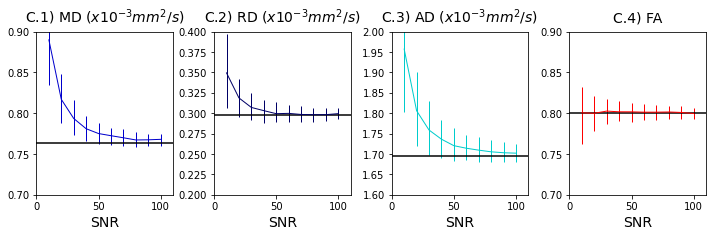

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.subplots_adjust(hspace=1, wspace=0.3)

# Initializing vectors for statistics
median_p = np.empty(SNRs.size)
lower_p = np.empty(SNRs.size)
upper_p = np.empty(SNRs.size)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MDpy[snri, :])
    p25, p75 = np.percentile(MDpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[0].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.0, 0.8], ecolor= [0.0, 0.0, 0.8],
                linewidth=1.0)
axs[0].hlines(md_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
# axs[0].set_ylim([md_gt*1000*0.9, md_gt*1000*1.1])
axs[0].set_xlim([0, 110])
axs[0].set_xlabel('SNR', fontsize=14)
axs[0].set_title('C.1) MD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)


for snri in range(SNRs.size):
    median_p[snri] = np.median(RDpy[snri, :])
    p25, p75 = np.percentile(RDpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[1].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.0, 0.4], ecolor= [0.0, 0.0, 0.4],
                linewidth=1.0)
axs[1].hlines(rd_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[1].set_xlim([0, 110])
axs[1].set_xlabel('SNR', fontsize=14)
axs[1].set_title('C.2) RD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)



for snri in range(SNRs.size):
    median_p[snri] = np.median(ADpy[snri, :])
    p25, p75 = np.percentile(ADpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[2].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.8, 0.8], ecolor= [0.0, 0.8, 0.8],
                linewidth=1.0)
axs[2].hlines(ad_gt*1000, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[2].set_xlim([0, 110])
axs[2].set_xlabel('SNR', fontsize=14)
axs[2].set_title('C.3) AD ($x10^{-3}mm^{2}/s$)', fontsize=14, pad=10)

for snri in range(SNRs.size):
    median_p[snri] = np.median(FApy[snri, :])
    p25, p75 = np.percentile(FApy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[3].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[1.0, 0.0, 0.0], ecolor= [1.0, 0.0, 0.0],
                linewidth=1.0)
axs[3].hlines(fa_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
axs[3].set_xlim([0, 110])
axs[3].set_xlabel('SNR', fontsize=14)
axs[3].set_title('C.4) FA', fontsize=14, pad=10)


axs[0].set_ylim([0.7, 0.9])
axs[1].set_ylim([0.2, 0.4])
axs[2].set_ylim([1.6, 2.0])
axs[3].set_ylim([0.7, 0.9])

(0.3, 1.0)

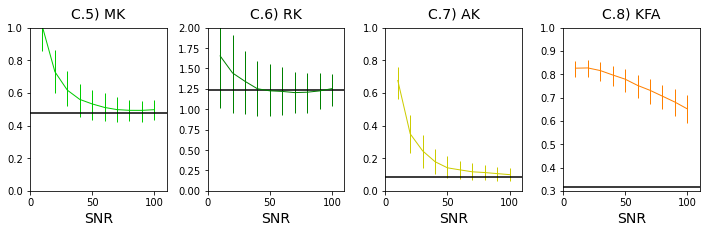

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Initializing vectors for statistics
median_p = np.empty(SNRs.size)
lower_p = np.empty(SNRs.size)
upper_p = np.empty(SNRs.size)

for snri in range(SNRs.size):
    median_p[snri] = np.median(MKpy[snri, :])
    p25, p75 = np.percentile(MKpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[0].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.8, 0.0], ecolor= [0.0, 0.8, 0.0],
                linewidth=1.0)
axs[0].hlines(mk_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
# axs[0].set_ylim([md_gt*1000*0.9, md_gt*1000*1.1])
axs[0].set_xlim([0, 110])
axs[0].set_xlabel('SNR', fontsize=14)
axs[0].set_title('C.5) MK', fontsize=14, pad=10)


for snri in range(SNRs.size):
    median_p[snri] = np.median(RKpy[snri, :])
    p25, p75 = np.percentile(RKpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[1].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.0, 0.5, 0.0], ecolor= [0.0, 0.5, 0.0],
                linewidth=1.0)
axs[1].hlines(rk_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[1].set_xlim([0, 110])
axs[1].set_xlabel('SNR', fontsize=14)
axs[1].set_title('C.6) RK', fontsize=14, pad=10)



for snri in range(SNRs.size):
    median_p[snri] = np.median(AKpy[snri, :])
    p25, p75 = np.percentile(AKpy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[2].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[0.8, 0.8, 0.0], ecolor= [0.8, 0.8, 0.0],
                linewidth=1.0)
axs[2].hlines(ak_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
#axs[0].set_ylim([, 1.2])
axs[2].set_xlim([0, 110])
axs[2].set_xlabel('SNR', fontsize=14)
axs[2].set_title('C.7) AK', fontsize=14, pad=10)

for snri in range(SNRs.size):
    median_p[snri] = np.median(KFApy[snri, :])
    p25, p75 = np.percentile(KFApy[snri, :], [25, 75])
    lower_p[snri] = median_p[snri] - p25 
    upper_p[snri] = p75 - median_p[snri]

axs[3].errorbar(SNRs, median_p, fmt='-', yerr=[lower_p, upper_p],
                color=[1, 0.5, 0.], ecolor=[1, 0.5, 0.],
                linewidth=1.0)
axs[3].hlines(kfa_gt, xmin=0, xmax=110, colors=[0, 0, 0])

# Adjust properties of the first panel of the figure
axs[3].set_xlim([0, 110])
axs[3].set_xlabel('SNR', fontsize=14)
axs[3].set_title('C.8) KFA', fontsize=14, pad=10)

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 2])
axs[2].set_ylim([0, 1])
axs[3].set_ylim([0.3, 1])